# Two-dimensional data with bottleneck

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Create sklearn.datasets.make_moons() data sets of varying sizes

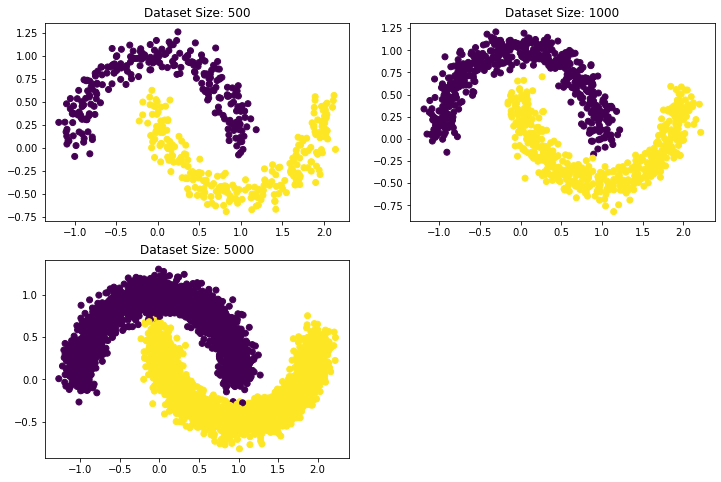

In [28]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

Next we implement the Autoencoder class with variable length of hidden layers

In [3]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        encoder_layers = []
        decoder_layers = []
        
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size)) 
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Lets define the training and testing function with the demanded parameters

In [34]:
# Training function
def train_autoencoder(model, train_datasets, val_datasets, dataset_size=1000, num_epochs=100, batch_size=32, learning_rate=0.001):
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader
    
    train_loader = torch.utils.data.DataLoader(train_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    
    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())
        
        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}')
    return epoch_train_losses, epoch_val_losses

Checking training functionality:

In [24]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 100
layers = 2
dataset_size=1000


autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
_ = train_autoencoder(autoencoder, train_datasets, dataset_size=1000,num_epochs=200)
print("Mean squared reconstruction loss on test dataset:",
       test_autoencoder(autoencoder,test_datasets, dataset_size))

Epoch [10/200], Loss: 2.5318
Epoch [20/200], Loss: 0.6555
Epoch [30/200], Loss: 0.3839
Epoch [40/200], Loss: 0.2662
Epoch [50/200], Loss: 0.2075
Epoch [60/200], Loss: 0.1883
Epoch [70/200], Loss: 0.1771
Epoch [80/200], Loss: 0.1527
Epoch [90/200], Loss: 0.1442
Epoch [100/200], Loss: 0.1340
Epoch [110/200], Loss: 0.1357
Epoch [120/200], Loss: 0.1355
Epoch [130/200], Loss: 0.1306
Epoch [140/200], Loss: 0.1286
Epoch [150/200], Loss: 0.1323
Epoch [160/200], Loss: 0.1316
Epoch [170/200], Loss: 0.1257
Epoch [180/200], Loss: 0.1424
Epoch [190/200], Loss: 0.1290
Epoch [200/200], Loss: 0.1280
Mean squared reconstruction loss on test dataset: 0.008382718078792095


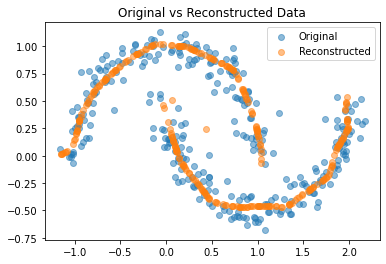

In [6]:
# Function to visualize original and reconstructed data
def visualize_results(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
    plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
    plt.title('Original vs Reconstructed Data')
    plt.legend()
    plt.show()

# Visualize results on the test dataset
visualize_results(autoencoder, test_datasets[dataset_size]['X'])

In order to not a have a exploding search space, we first analyze the number of epochs in relation to the dataset size

In [43]:
# Define the hyperparameter values to explore
hidden_sizes = [50, 100, 200]
layers = [2, 5, 10]
learning_rates = [0.0005, 0.001, 0.003]
epochs = [100,250,500]
dataset_sizes = [500, 1000, 5000]

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=dataset_size, num_epochs=400)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()

    

Epoch [10/400], Loss: 0.0627
Epoch [20/400], Loss: 0.0409
Epoch [30/400], Loss: 0.0375
Epoch [40/400], Loss: 0.0314
Epoch [50/400], Loss: 0.0245
Epoch [60/400], Loss: 0.0161
Epoch [70/400], Loss: 0.0148
Epoch [80/400], Loss: 0.0097
Epoch [90/400], Loss: 0.0077
Epoch [100/400], Loss: 0.0090
Epoch [110/400], Loss: 0.0107
Epoch [120/400], Loss: 0.0075
Epoch [130/400], Loss: 0.0070
Epoch [140/400], Loss: 0.0076
Epoch [150/400], Loss: 0.0073
Epoch [160/400], Loss: 0.0067
Epoch [170/400], Loss: 0.0062
Epoch [180/400], Loss: 0.0071
Epoch [190/400], Loss: 0.0061
Epoch [200/400], Loss: 0.0062
Epoch [210/400], Loss: 0.0073
Epoch [220/400], Loss: 0.0070
Epoch [230/400], Loss: 0.0069
Epoch [240/400], Loss: 0.0059
Epoch [250/400], Loss: 0.0065
Epoch [260/400], Loss: 0.0062
Epoch [270/400], Loss: 0.0063
Epoch [280/400], Loss: 0.0059
Epoch [290/400], Loss: 0.0057
Epoch [300/400], Loss: 0.0059
Epoch [310/400], Loss: 0.0060
Epoch [320/400], Loss: 0.0063
Epoch [330/400], Loss: 0.0057
Epoch [340/400], Lo

The best performance is achieved for the biggest dataset, however

Epoch [10/200], Loss: 0.0461
Epoch [20/200], Loss: 0.0337
Epoch [30/200], Loss: 0.0309
Epoch [40/200], Loss: 0.0275
Epoch [50/200], Loss: 0.0226
Epoch [60/200], Loss: 0.0190
Epoch [70/200], Loss: 0.0148
Epoch [80/200], Loss: 0.0151
Epoch [90/200], Loss: 0.0123
Epoch [100/200], Loss: 0.0115
Epoch [110/200], Loss: 0.0101
Epoch [120/200], Loss: 0.0122
Epoch [130/200], Loss: 0.0101
Epoch [140/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0087
Epoch [160/200], Loss: 0.0087
Epoch [170/200], Loss: 0.0084
Epoch [180/200], Loss: 0.0084
Epoch [190/200], Loss: 0.0081
Epoch [200/200], Loss: 0.0084
Epoch [10/200], Loss: 0.0372
Epoch [20/200], Loss: 0.0324
Epoch [30/200], Loss: 0.0256
Epoch [40/200], Loss: 0.0199
Epoch [50/200], Loss: 0.0149
Epoch [60/200], Loss: 0.0132
Epoch [70/200], Loss: 0.0110
Epoch [80/200], Loss: 0.0104
Epoch [90/200], Loss: 0.0099
Epoch [100/200], Loss: 0.0096
Epoch [110/200], Loss: 0.0088
Epoch [120/200], Loss: 0.0082
Epoch [130/200], Loss: 0.0088
Epoch [140/200], Loss: 0.008

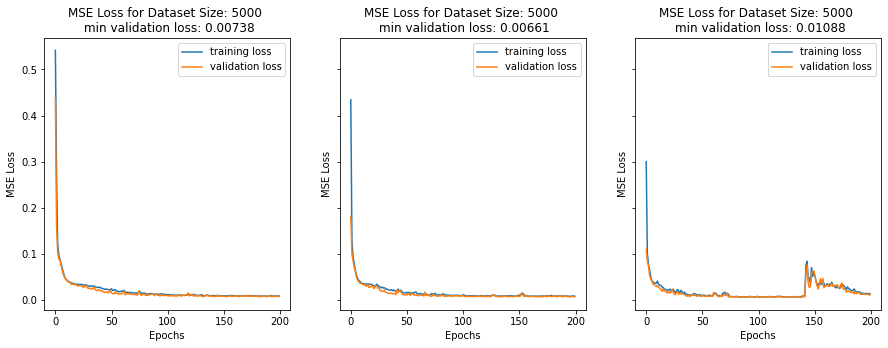

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=200, learning_rate=learning_rate)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()